In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from datetime import datetime
from helpers import *

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")


Using MPS


# Hyperparameters

In [2]:
seq_size = 30 # number of previous days used to predict next day
test_start_date = pd.to_datetime("2022-03-01")
out_cols = ['open', 'close', 'high', 'low', 'pct_change']
epochs = 500

In [3]:
# loading data
data_path = 'data'
interval = '1d'
# companies = os.listdir(data_path)
companies = ['AAPL']
for c in companies:
    if c == 'constituents.csv':
        companies.remove(c)
    elif c == '.DS_Store':
        companies.remove('.DS_Store')

# make unique number for each company ticker
ids = np.linspace(0, 1, len(companies)).round(5)
company_stats = dict() # keys are ticker, values are that company's stat dict
num_to_ticker = dict()
ticker_to_num = dict()
for i, num in enumerate(ids):
    num_to_ticker[num] = companies[i]
    ticker_to_num[companies[i]] = num

df_list = []
stats_list = []
x_train = []
x_test = []
y_train = []
y_test = []
dates = []

for co in companies:
    files = os.listdir(os.path.join(data_path, co))
    for f in files: # check each company folder for specific interval of data
        if interval in f:
            file = f

    df = pd.read_csv(os.path.join(data_path, co, file))
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop(columns=['Unnamed: 0'])

    # normalize columns, excluding date column
    df_normed, stat_dict = z_norm(df, 'date')
    # add ticker column
    df_normed['ticker'] = ticker_to_num[co]

    cols = list(df_normed.columns)
    cols.append(cols.pop(cols.index('date'))) # move date to end of list since this will be the order of columns for output df

    # split each df into train and test timeframes
    df_train = df_normed[df_normed['date'] < test_start_date]
    df_test = df_normed[df_normed['date'] >= test_start_date]

    pred_dates = df_test['date'].iloc[seq_size:].tolist()
    dates.append(pred_dates)

    # make copy of test df for use in testing
    # df_cpy = df_test.copy()

    # drop unnecessary columns
    df_train = df_train.drop(columns=['date'])
    df_test = df_test.drop(columns=['date'])

    # store column indices for extracting output features we want
    feature_cols_idx = [list(df_train.columns).index(feature) for feature in out_cols]

    # convert to 2D numpy arrays of shape (-1, num_cols)
    train = df_train.to_numpy()
    test = df_test.to_numpy()

    # convert to sequences and append to respective training and testing lists
    x, y = to_sequences(seq_size, train)
    for i in range(len(x)):
        x_train.append(x[i])
        y_train.append(y[i])
    x, y = to_sequences(seq_size, test)
    for i in range(len(x)):
        x_test.append(x[i])
        y_test.append(y[i])

    company_stats[co] = stat_dict
    stats_list.append(stat_dict)

indims = y_train[0].shape[0]
outdims = 5 # open, close, high, low, pct_change
batch_size = 32
dates = [element for nestedlist in dates for element in nestedlist]

x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
y_train = np.vstack(y_train).reshape(-1, indims)
x_test = np.vstack(x_test).reshape(-1, seq_size, indims)
y_test = np.vstack(y_test).reshape(-1, indims)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using basic transformer from https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb

In [4]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel(input_dim=indims, output_dim=outdims).to(device)

In [5]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, verbose=True)

early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            y_batch = y_batch[:, feature_cols_idx]
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    train_loss = np.mean(train_losses)
    scheduler.step(val_loss)

    # uncomment for early stopping
    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     early_stop_count = 0
    # else:
    #     early_stop_count += 1

    # if early_stop_count >= 5:
    #     print("Early stopping!")
    #     break
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/500, Train Loss: 0.2938, Validation Loss: 0.3562


KeyboardInterrupt: 

In [7]:
saved_weights_path = 'saved_models'
fn = f'AAPL_model_{datetime.now().strftime("%Y%m%d")}.pt'

In [8]:
torch.save(model.state_dict(), os.path.join(saved_weights_path, fn))

# Testing

In [6]:
# testing with metrics
# model = TransformerModel(input_dim=indims, output_dim=outdims).to(device)
# model.load_state_dict(torch.load(os.path.join(saved_weights_path, "AAPL_model_20240209.pt")))
results = []
gt_preds = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        x_batch, y_batch = batch
        tickers = [num_to_ticker[y_batch.detach().numpy()[idx,-1]] for idx in range(y_batch.shape[0])]
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)

        gt_outputs = process_results(y_batch, batch_size, i, dates, tickers)
        processed_outputs = process_results(outputs, batch_size, i, dates, tickers)

        [results.append(out) for out in processed_outputs]
        [gt_preds.append(out) for out in gt_outputs]

columns = [ele for nested in [out_cols, ['ticker', 'date']] for ele in nested]
df_pred = pd.DataFrame(results, columns=columns)
df_gt = pd.DataFrame(gt_preds, columns=columns)
for co in companies:
    df_pred[df_pred['ticker'] == co] = reverse_z_norm(df_pred, company_stats[co], col_exclude=['ticker', 'date'])
    df_gt[df_pred['ticker'] == co] = reverse_z_norm(df_gt, company_stats[co], col_exclude=['ticker', 'date'])

In [7]:
df_pred.head()

,open,close,high,low,pct_change,ticker,date
0,153.775142,149.539862,150.114000,154.689061,-0.001818,AAPL,2022-04-12
1,153.914558,147.995298,153.097797,146.642164,0.001304,AAPL,2022-04-13
2,151.465824,156.482587,155.626065,157.442929,0.000304,AAPL,2022-04-14
3,133.543676,147.787449,150.065785,144.393616,0.001929,AAPL,2022-04-18
4,138.575089,142.715087,142.711835,151.942139,0.002542,AAPL,2022-04-19


In [8]:
df_gt.head()

,open,close,high,low,pct_change,ticker,date
0,168.020001,167.659998,169.870002,166.639999,0.011523,AAPL,2022-04-12
1,167.390000,170.400002,171.040003,166.769999,0.016343,AAPL,2022-04-13
2,170.619998,165.290002,171.269997,165.040001,-0.029988,AAPL,2022-04-14
3,163.920000,165.069997,166.599998,163.570002,-0.001331,AAPL,2022-04-18
4,165.020000,167.400003,167.819997,163.910002,0.014115,AAPL,2022-04-19


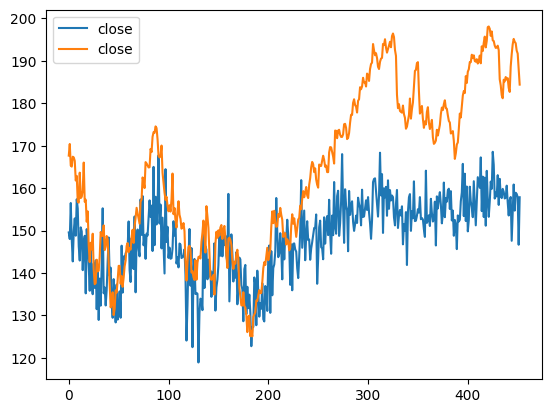

In [9]:
df_pred[df_pred['ticker'] == 'AAPL']['close'].plot()
df_gt[df_gt['ticker'] == 'AAPL']['close'].plot()
plt.legend()
plt.show()

In [10]:
directional_accuracy(df_gt['open'], df_pred['open'])

0.5022123893805309

In [11]:
directional_accuracy(df_gt['close'], df_pred['high'])

0.5110619469026548